In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision import utils
# from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
# from skimage import transform, io 
# from skimage.draw import rectangle_perimeter

from PIL import Image
import sys
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
train_tx = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
      # torchvision.transforms.Normalize((0.3, 0.25, 0.3), 
      #                         (0.4, 0.3, 0.4)),
  ])

In [ ]:
df = pd.read_csv("./drive/MyDrive/Bird/after.csv")

train_list = list()

for index, row in df.iterrows():
    filename= df.iloc[index]['filename']
    point_num = df.iloc[index]['num']
    img_shape = df.iloc[index]['shape']
    
    point_list = eval(df.iloc[index]['points'])
#     for j in range(len(point_list)):
#         x, y = point_list[j]
    
    train_list.append([filename, point_num, img_shape, point_list])


# file = list(df["filename"])
# pts = list(df["points"])
# shape = list(df["shape"])
# n = len(pts)
# for i in range(n):
#     pts[i] = eval(pts[i])
#     shape[i] =  eval(shape[i])1

In [ ]:
crop_size = 512
output_size = 256
crop_ratio = 0.25

In [ ]:
def local_max(x):
  size = x.shape
  up = torch.zeros(size)
  up[:,:,:-1,:] = x[:,:,:-1,:]>x[:,:,1:,:]
  down = torch.zeros(size)
  down[:,:,1:,:] = x[:,:,1:,:]>x[:,:,:-1,:]
  right = torch.zeros(size)
  right[:,:,:,1:] = x[:,:,:,1:]>x[:,:,:,:-1]
  left = torch.zeros(size)
  left[:,:,:,:-1] = x[:,:,:,:-1]>x[:,:,:,1:]
  return up*down*right*left

In [ ]:
#del Dataset
def gaussian_filter(sigma=10,size = 19):
    global π
    π = np.pi
    x, y = np.mgrid[-size:size+1,-size:size+1]
    gaussian_kernel = np.sqrt(2*π*sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))
    #Normalization
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
    return gaussian_kernel
class Dataset(torch.utils.data.Dataset):
    def __init__(self,csv, images_path,crop_ratio,transform=None):
        self.train_set=csv
        self.train_path=images_path
        self.transform=transform
        self.crop_ratio = crop_ratio
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set[idx][0]
#         img = io.imread(file_name)[:, :, :3]
#         print(file_name)
        img = Image.open(self.train_path + file_name).convert('RGB')
#         print('img size= ', img.size)
        num = self.train_set[idx][1]
        pic_width, pic_height=img.size
        output_width = output_size
        output_height = output_size
        label = np.zeros((output_height,output_width,1)) ##numchange
#         mask = np.zeros((output_height, output_))
            
#         print('img.size = ', img.size)
        if pic_height < crop_size or pic_width < crop_size:
            img = img.resize((crop_size, crop_size))
            img = torchvision.transforms.functional.resize(img, (crop_size, crop_size))
       
        if np.random.randint(0, 101) < self.crop_ratio * 100 and pic_height > crop_size and pic_width > crop_size:
            new_h, new_w = (crop_size, crop_size)
            top = np.random.randint(0, pic_height - new_h)
            left = np.random.randint(0, pic_width - new_w)
            img = img.crop((left, top, left + new_w, top + new_h))
            
        
        else:
            new_w, new_h = img.size
            top = 0
            left = 0
#             img = img.resize((crop_size, crop_size))
            img = torchvision.transforms.functional.resize(img, (crop_size, crop_size))
            

    
        tt = np.zeros((output_height,output_width,1))
        for annotation in self.train_set[idx][3]: 
            annotation = list(annotation)
            if annotation[0] < left or annotation[1] < top or annotation[0] >= (left + new_w) or annotation[1] >= (top + new_h):
                continue
            # ignore the character that exceed to much to the boundary
#             if (annotation[1] + (annotation[3] / 2)) >= (left + new_w) or (annotation[2] + (annotation[4] / 2)) >= (top + new_h): 
#                 continue
    
            x_c = (annotation[0] - left) * (output_width / new_w)
            y_c = (annotation[1] - top)  * (output_height / new_h)
#             width = output_width * 1/2 * (output_width / new_w)
#             height = output_height * 1/2 * (output_height / new_h)
# #             width = annotation[3] * (output_width / new_w)
# #             height = annotation[4] * (output_height / new_h)
    
#             heatmap=((np.exp(-(((np.arange(output_width) - x_c)/(width/10))**2)/2)).reshape(1,-1)
#                     *(np.exp(-(((np.arange(output_height) - y_c)/(height/10))**2)/2)).reshape(-1,1))
            kernel = gaussian_filter(sigma = 7)
            gt = np.zeros((output_height,output_width,1))
            gt[int(y_c // 1), int(x_c // 1), 0] = 1
            tt+=gt
            gt = cv2.filter2D(gt,-1,kernel)
            gt = gt[..., np.newaxis]
            # label = np.maximum(label,gt)
            label+=gt
            # label[:,:,0]=np.maximum(label[:,:,0],heatmap[:,:])
            # label[int(y_c // 1), int(x_c // 1), 0] = 1  ##numchange
#             label[int(y_c // 1),int(x_c // 1),2] = y_c % 1
#             label[int(y_c // 1),int(x_c // 1),3] = x_c % 1
#             label[int(y_c // 1), int(x_c // 1), 4] = height / output_size 
#             label[int(y_c // 1), int(x_c // 1), 5] = width / output_size
            
#         sample = {'image': img, 'labels': label}
        ksum = label[..., 0].sum()
        ksum = torch.Tensor([ksum])
        if self.transform:
            img = self.transform(img)
            ksum = torch.Tensor([ksum])
#             sample = self.transform(sample)
        sample = {'image': img, 'labels': label,'num': ksum,"gt":tt}
        return sample

In [ ]:
#del train_set
train_set = Dataset(train_list, './drive/MyDrive/Bird/jpg/', crop_ratio=0.25, transform=train_tx)

num of birds : 47

torch.Size([3, 512, 512]) (256, 256, 1)
bsum =  <class 'torch.Tensor'>
(256, 256)
nonzero: 24253 / 65536


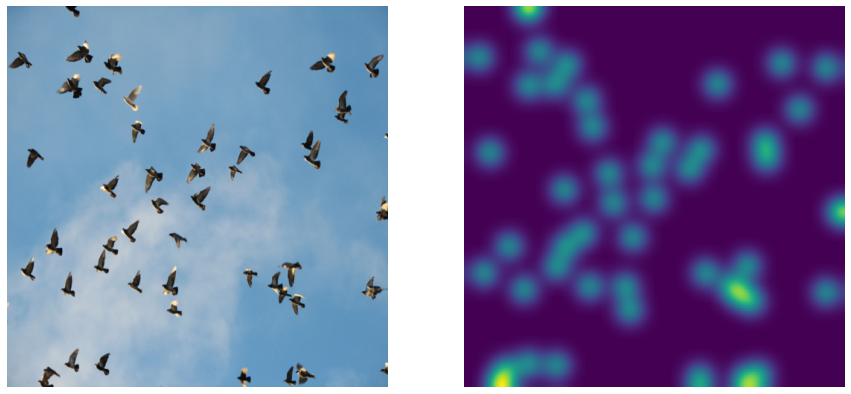

num of birds : 14

torch.Size([3, 512, 512]) (256, 256, 1)
bsum =  <class 'torch.Tensor'>
(256, 256)
nonzero: 47255 / 65536


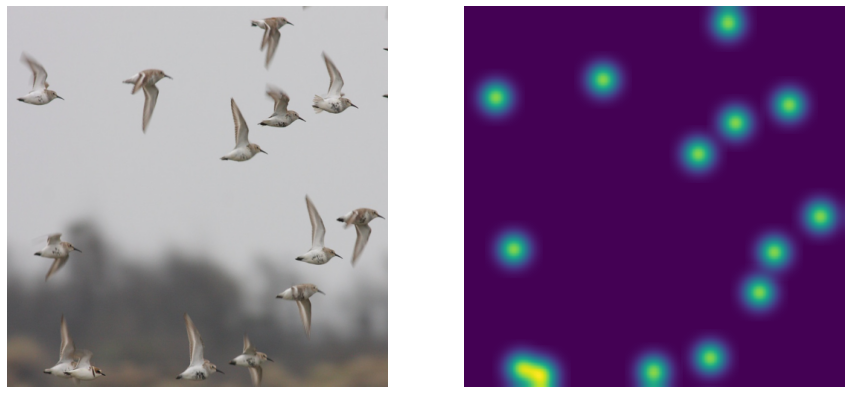

num of birds : 15

torch.Size([3, 512, 512]) (256, 256, 1)
bsum =  <class 'torch.Tensor'>
(256, 256)
nonzero: 52393 / 65536


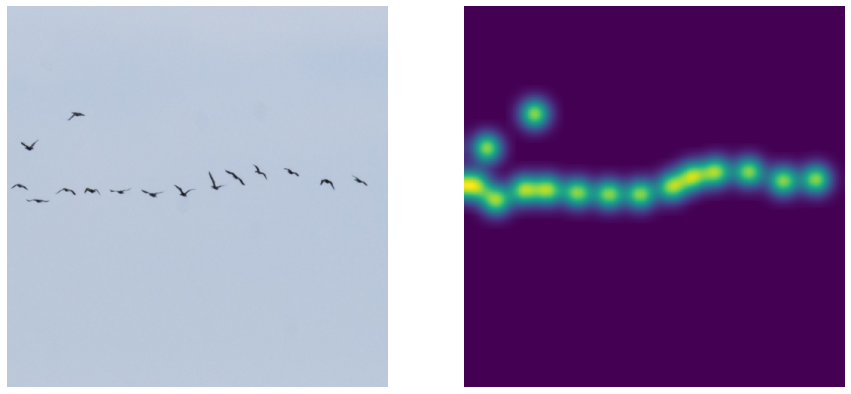

num of birds : 23

torch.Size([3, 512, 512]) (256, 256, 1)
bsum =  <class 'torch.Tensor'>
(256, 256)
nonzero: 38644 / 65536


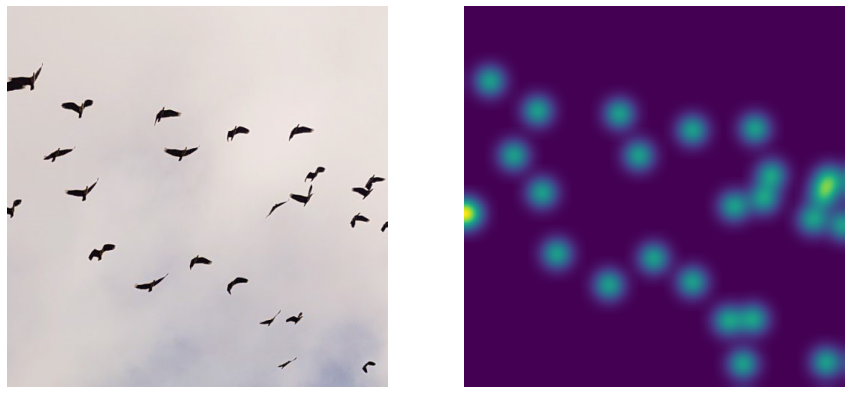

num of birds : 36

torch.Size([3, 512, 512]) (256, 256, 1)
bsum =  <class 'torch.Tensor'>
(256, 256)
nonzero: 30711 / 65536


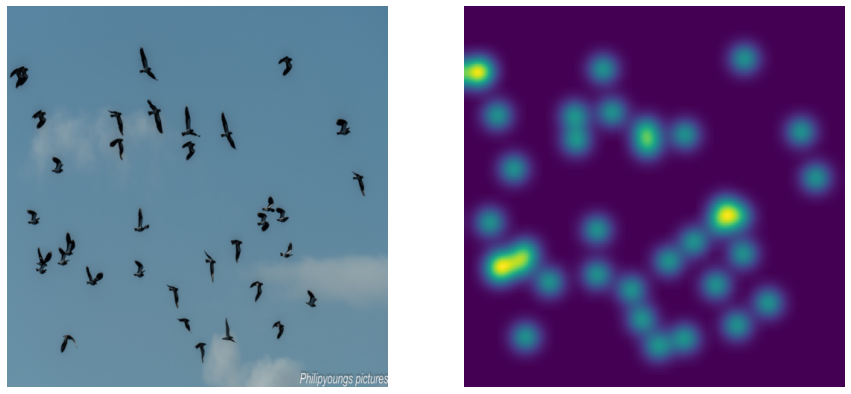

In [ ]:
for i in range(75, 80):
    sample = train_set[i]
    print("num of birds : %d\n"%sample["num"])
    fig, axes = plt.subplots(1, 2,figsize=(15,20))

    print(sample['image'].shape, sample['labels'].shape)

    sam = torch.transpose(torch.Tensor(sample['labels']),0,2)
    image = sample['image']
    heatmap = sample['labels'][..., 0] ##numchange
    bsum = sample['num'] ##numchange
    print('bsum = ', type(bsum))
#     height_map = sample['labels'].data.cpu().numpy()[...,4]
#     width_map = sample['labels'].data.cpu().numpy()[...,5]
    
    print(heatmap.shape)
    #     print(image.transpose(1, 2, 0).shape)
    print("nonzero:",np.count_nonzero((heatmap<1e-10)/1.0),"/",256*256)
    out = np.asarray(image).transpose((1, 2, 0))
    heatmap = np.asarray(heatmap)
    axes[0].set_axis_off()
    axes[0].imshow(out)
    
#     print(out)
    axes[1].set_axis_off()
    axes[1].imshow(heatmap)
    
    plt.show()
    

In [ ]:
import torch.nn as nn
from torchvision import models
def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
import collections
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 'CT', 256, 'CT', 128, 64]
        self.frontend = make_layers(self.frontend_feat,batch_norm=True)
        self.backend = make_layers(self.backend_feat,in_channels = 512,batch_norm=True,dilation = True)
        self.output_layer =nn.Sequential(nn.Conv2d(64, 1, kernel_size=1),nn.ReLU())
                                           
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            fsd=collections.OrderedDict()
            for i in range(len(self.frontend.state_dict().items())):#10个卷积*（weight，bias）=20个参数
                
                temp_key=list(self.frontend.state_dict().items())[i][0]
                fsd[temp_key] = list(mod.state_dict().items())[i][1]
            self.frontend.load_state_dict(fsd)
            
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False ,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v =='m':
            layers+= [nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)]
        elif v == 'CT':
            layers += [nn.ConvTranspose2d(in_channels,in_channels,kernel_size = 6,stride = 2,padding = (2,2))]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)            

In [ ]:
model = CSRNet()

In [ ]:
print(model)

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
def comb_loss(pred, gt, num,metric = {}):
    mse = nn.MSELoss(size_average=False)
    mseloss = mse(pred,gt)
    maeloss = torch.abs(torch.sum(num)-torch.sum(pred))
    metric['mse'] = mseloss.item()
    metric['mae'] = maeloss.item()
    
    
    return (mseloss*0.7 +maeloss*0.3)/(torch.sum(num)+1)

In [ ]:
def calc_loss(pred, label, gt,metrics = {}):
    N = torch.sum(gt)
    _heatmap_loss = heatmap_loss(pred, label , gt)
    # _size_loss = size_loss(pred, gt, mask)
    _focal_loss = focal(pred,label,N)
    all_loss = (-1 * _heatmap_loss + 5. * _focal_loss) / (N+1)#10. * _size_loss + 
    
    metrics['loss'] = all_loss.data.cpu().numpy().item() 
    metrics['hloss'] = (-1 * _heatmap_loss / (N + 1)).data.cpu().numpy().item()
    # metrics['size'] = (10. * _size_loss / (N+1)).item()
    metrics['focal'] = (5. * _focal_loss) / (N+1).item()
    return all_loss

def heatmap_loss(pred, label , gt):
    
    alpha = 2.
    beta = 4.
    
    heatmap_gt_rate = torch.flatten(label)
    heatmap_gt = torch.flatten(gt)
    heatmap_pred = torch.flatten(pred)
    
    heatloss = torch.sum(heatmap_gt * ((1 - heatmap_pred) ** alpha) * torch.log(heatmap_pred + 1e-7) + 
              (1 - heatmap_gt) * ((1 - heatmap_gt_rate) ** beta) * (heatmap_pred ** alpha) * torch.log(1 - heatmap_pred + 1e-7))
    
    return heatloss
# def size_loss(pred, gt, mask, metrics):
    
#     sizeloss = torch.sum(torch.abs(gt[...,4] - pred[:,3, ...]*mask) + torch.abs(gt[...,5] - pred[:,4,...] * mask))
    
#     return sizeloss
def focal(pred,label,num):
    a=3
    b=7
    c=1
    mse = nn.MSELoss(size_average=False)
    mask = label<1e-10
    bkloss = mse(pred[mask],label[mask])
    prosloss = mse(pred[label>=1e-7],label[label>=1e-7])
    maeloss = torch.abs(torch.sum(num)-torch.sum(pred))
    return (a*bkloss + b*prosloss + c*maeloss)/11

In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# 
batch_size    = 12
momentum      = 0.85
decay         = 5*1e-4

num_epochs = 1500
model = CSRNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Bird/weight_final/MSE_76_0.3.pth"))
    
model = model.train()
# criterion = nn.MSELoss(size_average=False).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5,
                            weight_decay=decay)
batch_split = 1

accum_steps = 0
batch_count = 0

dataloaders = {'train': torch.utils.data.DataLoader(train_set,
                        batch_size=batch_size,
                        shuffle=True)
              }

In [ ]:
for epoch in range(num_epochs):
    loss = 0.
    batch_count = 0
    
    for phase in ['train']:
        if phase == 'train':
            model.train() 
        else:
            model.eval() 
        kk = len(dataloaders['train'].dataset)
        for batch_idx, sample in enumerate(dataloaders[phase]):
            metrics = {}
            if phase=='train':
                inputs = sample['image'].to(device, dtype=torch.float)
                labels = sample['labels'].to(device, dtype=torch.float)
                sum = sample['num'].to(device, dtype=torch.float)
                gt = sample['gt'].to(device, dtype=torch.float)
                outputs = model(inputs)
                outputs = outputs.permute(0,2,3,1)
                # outputs = outputs.reshape(batch_size,256,256,1)
                
                loss = comb_loss(outputs,labels,sum,metrics)
                # loss = calc_loss(outputs, labels, gt, metrics)
                # loss = focal(outputs,labels,sum,metric)
                #loss = criterion(outputs,labels)



                loss.backward()
                accum_steps = accum_steps  + 1
                sys.stdout.write('\r')
                

                optimizer.step()
                optimizer.zero_grad()   
                accum_steps = 0
                batch_count = batch_count + 1    
                
                sys.stdout.write('Epoch [%3d/%3d] Iter[%3d/%3d] MSE: %.4f MAE: %d\tLoss: %.4f'%(epoch+1, num_epochs, batch_count, kk//(batch_size)+1,metrics["mse"],metrics["mae"],loss.item()))
                # sys.stdout.write('Epoch [%3d/%3d] Iter[%3d/%3d] BKL: %.4f PRL: %d\tLoss: %.4f'%(epoch+1, num_epochs, batch_count, kk//(batch_size)+1,metric["background_loss"],metric["prospect_loss"],loss.item()))
                # sys.stdout.write('Epoch [%3d/%3d] Iter[%3d/%3d] all_loss: %.4f heat_loss: %.4f focal_loss: %.4f'
                #           %(epoch+1, num_epochs, batch_count, kk//(batch_size)+1,metrics["loss"],metrics["hloss"],metrics["focal"]))
                sys.stdout.flush()
        loss = round(loss.item(),2)
        if epoch%25 == 0 or epoch>1400:
          torch.save(model.state_dict(), './drive/MyDrive/Bird/weight_final/MSE_' +str(epoch+1)+ "_" + str(loss)+'.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [  8/1500] Iter[ 17/ 18] MSE: 0.4708 MAE: 15	Loss: 0.0214

In [ ]:
modelt = CSRNet(load_weights=True)
modelt.load_state_dict(torch.load("/content/drive/MyDrive/Bird/weight/epoch201_1654.06_focal.pth",map_location=torch.device('cpu')))
modelt.eval()

# im = Image.open("./drive/MyDrive/Bird/test/test.jpg")
im = Image.open("/content/drive/MyDrive/Bird/test/test1.jpg")

im1 = im.resize( (512,512), Image.BILINEAR )
test_tx = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
      # torchvision.transforms.Normalize((0.3,0.4,0.3), 
      #                         (0.5, 0.5, 0.5)),
  ])
im2 = test_tx(im1).unsqueeze(0)
output = modelt(im2)
output = output.squeeze()
output = output.detach().numpy()

RuntimeError: ignored

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(121)
plt.imshow(np.array(im1))
plt.axis("off")
plt.subplot(122)
plt.imshow(output)
plt.axis("off")

In [ ]:
np.sum(output[:128,:])

In [ ]:
import numpy as np
from scipy.signal import argrelextrema
x = np.random.randn(4,4)
argrelextrema(x, np.greater)

In [ ]:
x

In [ ]:
np.eye(2)*np.array([[1,5],[2,3]])

In [ ]:
x = torch.rand(2,1,4,4)

In [ ]:
y = torch.zeros(2,1,4,4)
y[:,:,:-1,:] = x[:,:,:-1,:]>x[:,:,1:,:]

In [ ]:
local_max(x)

In [ ]:
5%1